In [1]:
import gymnasium
import cookiedisaster
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque

In [2]:
env = gymnasium.make('cookiedisaster/GridWorld-v0', render_mode="rgb_array")

2. Use a linear approximation to approximate $q_\pi(a,s)$ and solve the control problem using Q-learning. 
You may want to consider the use of feature engineering to pre-process the state.

In [3]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [4]:
observation_examples = []

obs, _ = env.reset()
for _ in range(10000):
    action = env.action_space.sample()  # random policy
    next_obs, _, _, _, info = env.step(action)
    observation_examples.append(get_features(next_obs, info))

observation_examples = np.array(observation_examples)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

In [5]:
scaler = StandardScaler()
featurizer = FeatureUnion([
    ("rbf1", RBFSampler(gamma=4.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])

featurizer.fit_transform(scaler.fit_transform(observation_examples))

array([[-0.12748031, -0.04714233,  0.03443019, ...,  0.09791137,
         0.03520805,  0.11608126],
       [-0.12222045,  0.13851188,  0.01291545, ...,  0.14116441,
         0.02154277,  0.06512629],
       [-0.12090208, -0.05019532, -0.03458609, ...,  0.11583215,
         0.00364905, -0.00132027],
       ...,
       [ 0.11787635, -0.0412003 , -0.08263864, ..., -0.03861772,
         0.13364314,  0.12898438],
       [ 0.12352118, -0.11333098, -0.04474223, ...,  0.05027067,
         0.11839451,  0.14036975],
       [ 0.13178416,  0.13957423,  0.14042209, ...,  0.11325878,
         0.09311433,  0.1108994 ]])

In [6]:
class FunctionApproximator:
    def __init__(self):
        self.models = []
        # for each action there is separate SGDRegressor, which allows to 
        # estimate the Q-value for each action-state pair
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            obs, info = env.reset()
            # models are fitted with a default target value to set up the model
            model.partial_fit([self.featurize_state(get_features(obs, info))], [0])
            self.models.append(model)

    def featurize_state(self, state):
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]

    def predict(self, s):
        state_features = self.featurize_state(s)
        return np.array([model.predict([state_features])[0] for model in self.models])

    def update(self, state, action, target):
        features = self.featurize_state(state)
        self.models[action].partial_fit([features], [target])

In [7]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [8]:
def eps_greedy_policy(func_approx, epsilon, action_space):
    def policy_func(state):
        prob_distribution = np.ones(action_space) * epsilon / action_space
        q_values = func_approx.predict(state)
        best_action = random_argmax(q_values)
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [9]:
def q_learning(env, func_approx, num_episodes=100, num_steps=1000, discount_factor=1.0, epsilon_start=1.0,
               epsilon_decay=0.99, epsilon_min=0.1):
    episode_rewards = []

    epsilon = epsilon_start
    policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    for episode in range(1, num_episodes + 1):
        total_reward = 0

        obs, info = env.reset()
        state = get_features(obs, info)

        for step in range(1, num_steps + 1):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_features(next_obs, next_info)

            total_reward += reward

            q_values_next = func_approx.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)

            func_approx.update(state, action, td_target)

            state = next_state

        print(f"\rEpisode: {episode}/{num_episodes}   Reward: {total_reward:.3f}   Epsilon: {epsilon:.3f}", end="")

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)
        episode_rewards.append(total_reward)

    return episode_rewards

In [10]:
fa = FunctionApproximator()
lin_rewards = q_learning(env, fa)

Episode: 100/100   Reward: 31.329   Epsilon: 0.370

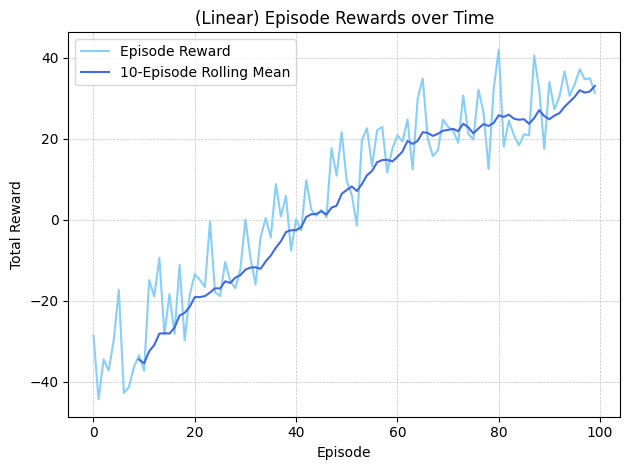

In [11]:
plt.plot(lin_rewards, color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(lin_rewards).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("(Linear) Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.out(x)

In [13]:
def select_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return torch.tensor([[env.action_space.sample()]])
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

In [14]:
def nn_q_learning(env, policy_net, loss_fn, num_episodes=100, num_steps=1000, discount_factor=1.0,
                  epsilon_start=1.0, epsilon_decay=0.99, epsilon_min=0.1):
    episode_rewards = []
    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):
        obs, info = env.reset()
        state = get_features(obs, info)
        state = scaler.transform([state])[0]
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        total_reward = 0

        for step in range(1, num_steps + 1):
            action = select_action(state, epsilon, policy_net)
            next_obs, reward, _, _, next_info = env.step(action.item())
            next_state = get_features(next_obs, next_info)
            next_state = scaler.transform([next_state])[0]
            next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)

            state_action_values = policy_net(state).gather(1, action).squeeze()

            next_state_values = policy_net(next_state)
            max_next_state_values = next_state_values.max()
            expected_state_action_values = reward + (discount_factor * max_next_state_values)

            loss = loss_fn(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward

        print(f"\rEpisode: {episode}/{num_episodes}   Reward: {total_reward:.3f}   Epsilon: {epsilon:.3f}", end="")

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        episode_rewards.append(total_reward)

    return episode_rewards

In [15]:
n_observations = len(get_features(*env.reset()))
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)

In [16]:
nn_rewards = nn_q_learning(env, policy_net, loss_fn)

Episode: 100/100   Reward: 29.131   Epsilon: 0.370

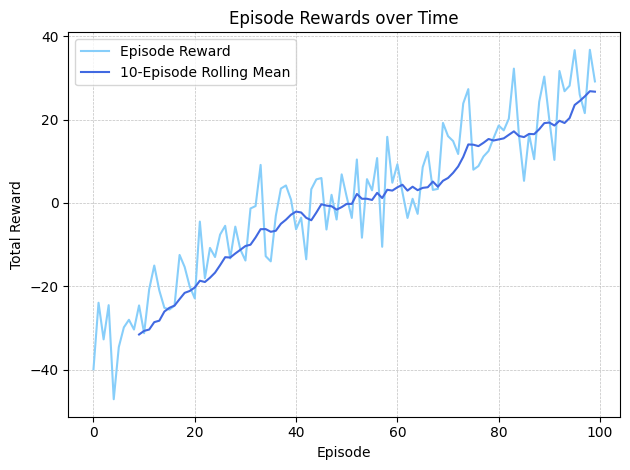

In [17]:
plt.plot(nn_rewards, color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(nn_rewards).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

7. Consider again the solution based on neural approximation of Q-learning. Try to improve your 
solution adding a replay buffer or a target network.

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
def update_target_model(target_net, policy_net):
    target_net.load_state_dict(policy_net.state_dict())

In [ ]:
def optimize_model(policy_net, target_net, replay_memory, optimizer, batch_size, discount_factor):
    if len(replay_memory) < batch_size:
        return

    transitions = replay_memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)

    # Former Q-value estimation
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q-value of next state using target network
    with torch.no_grad():
        next_state_values = target_net(next_state_batch).max(1).values

    # Compute expected Q-values (td target)
    expected_state_action_values = reward_batch + (next_state_values * discount_factor)

    # Compute loss
    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def select_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return torch.tensor([[env.action_space.sample()]])
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

In [ ]:
def improved_nn_q_learning(env, policy_net, target_net, replay_memory, optimizer, num_episodes=100, num_steps=1000,
                           discount_factor=1.0, epsilon_start=1.0, epsilon_decay=0.99, epsilon_min=0.1, batch_size=256,
                           target_update=10):
    episode_rewards = []
    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):
        obs, info = env.reset()
        state = get_features(obs, info)
        state = scaler.transform([state])[0]
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)

        total_reward = 0

        for step in range(1, num_steps + 1):
            action = select_action(state, epsilon, policy_net)
            next_obs, reward, _, _, next_info = env.step(action.item())
            next_state = get_features(next_obs, next_info)
            next_state = scaler.transform([next_state])[0]
            next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)

            # Store the transition in replay memory
            replay_memory.push(state, action, next_state, torch.tensor([reward], dtype=torch.float32))

            state = next_state
            total_reward += reward

            # Perform one step of the optimization (on the policy network)
            optimize_model(policy_net, target_net, replay_memory, optimizer, batch_size, discount_factor)

            # Update the target network, copying all weights and biases in DQN
            if episode % target_update == 0:
                update_target_model(target_net, policy_net)

        print(f"\rEpisode: {episode}/{num_episodes}  Reward: {total_reward:.3f}   Epsilon: {epsilon:.3f}", end="")

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        episode_rewards.append(total_reward)

    return episode_rewards

In [ ]:
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())

replay_memory = ReplayMemory(10000)

In [ ]:
improved_nn_rewards = improved_nn_q_learning(env, policy_net, target_net, replay_memory, optimizer)

In [ ]:
plt.plot(improved_nn_rewards, color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(improved_nn_rewards).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()